In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dilakshanchandrasena/dog-breed-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-breed-classification


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE

In [3]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/train_data.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
df.shape

(10222, 2)

In [5]:
df['breed'].nunique()

120

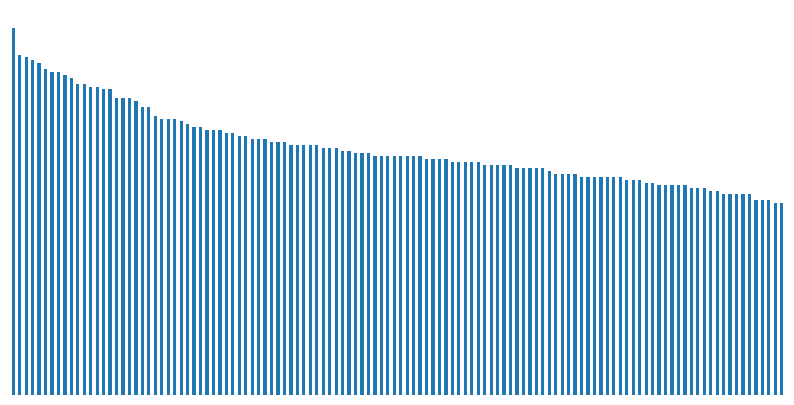

In [6]:
plt.figure(figsize=(10, 5))
df['breed'].value_counts().plot.bar()
plt.axis('off')
plt.show()

In [7]:
df['filepath'] = '/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/train_images/'  + df['id'] +'.jpg'
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/root/.cache/kagglehub/datasets/dilakshanchand...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/root/.cache/kagglehub/datasets/dilakshanchand...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/root/.cache/kagglehub/datasets/dilakshanchand...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/root/.cache/kagglehub/datasets/dilakshanchand...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/root/.cache/kagglehub/datasets/dilakshanchand...


In [8]:
df['filepath'][0]

'/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/train_images/000bec180eb18c7604dcecc8fe0dba07.jpg'

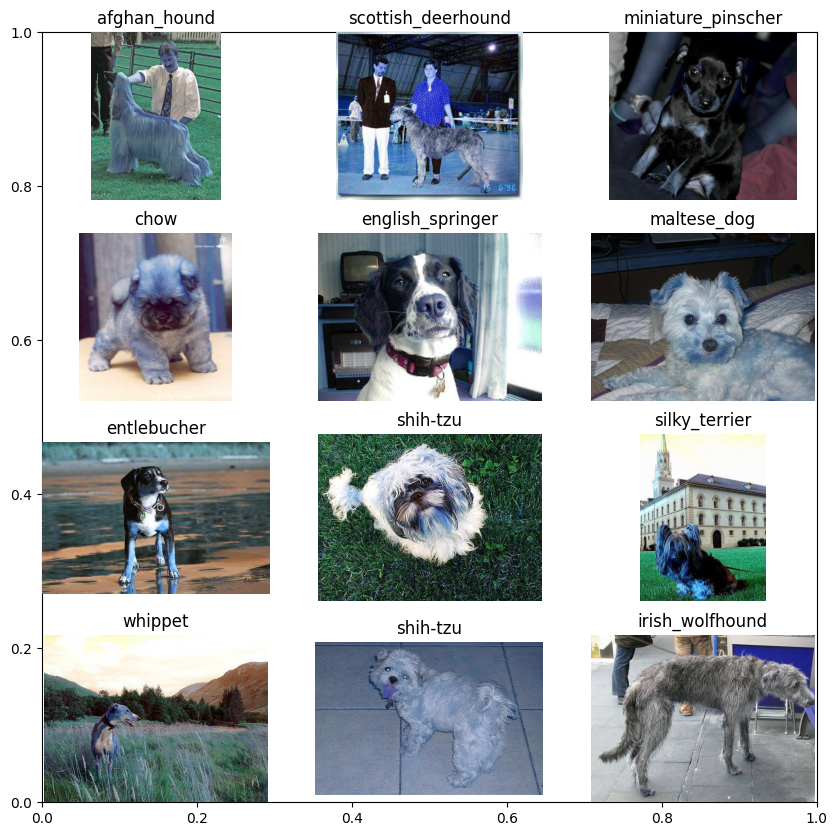

In [9]:
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image
    # index from the dataframe.
    k = np.random.randint(0, len(df))
    img = cv2.imread(df.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()

In [10]:
le = LabelEncoder()
df['breed'] = le.fit_transform(df['breed'])
df.head()

,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,/root/.cache/kagglehub/datasets/dilakshanchand...
1,001513dfcb2ffafc82cccf4d8bbaba97,37,/root/.cache/kagglehub/datasets/dilakshanchand...
2,001cdf01b096e06d78e9e5112d419397,85,/root/.cache/kagglehub/datasets/dilakshanchand...
3,00214f311d5d2247d5dfe4fe24b2303d,15,/root/.cache/kagglehub/datasets/dilakshanchand...
4,0021f9ceb3235effd7fcde7f7538ed62,49,/root/.cache/kagglehub/datasets/dilakshanchand...


In [11]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.15, random_state=10)

X_train.shape, X_val.shape

((8688,), (1534,))

In [12]:
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])

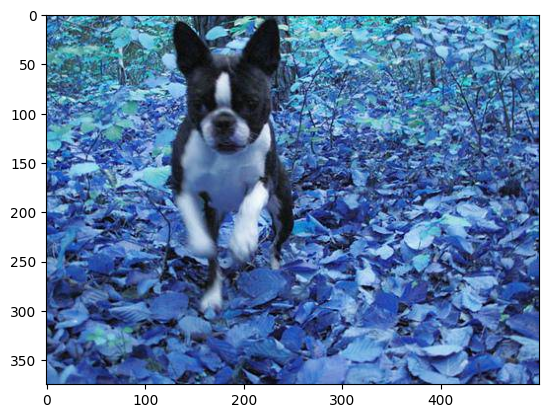

In [13]:
img = cv2.imread('/root/.cache/kagglehub/datasets/dilakshanchandrasena/dog-breed-classification/versions/1/DATASET/train_images/000bec180eb18c7604dcecc8fe0dba07.jpg')
plt.imshow(img)
plt.show()

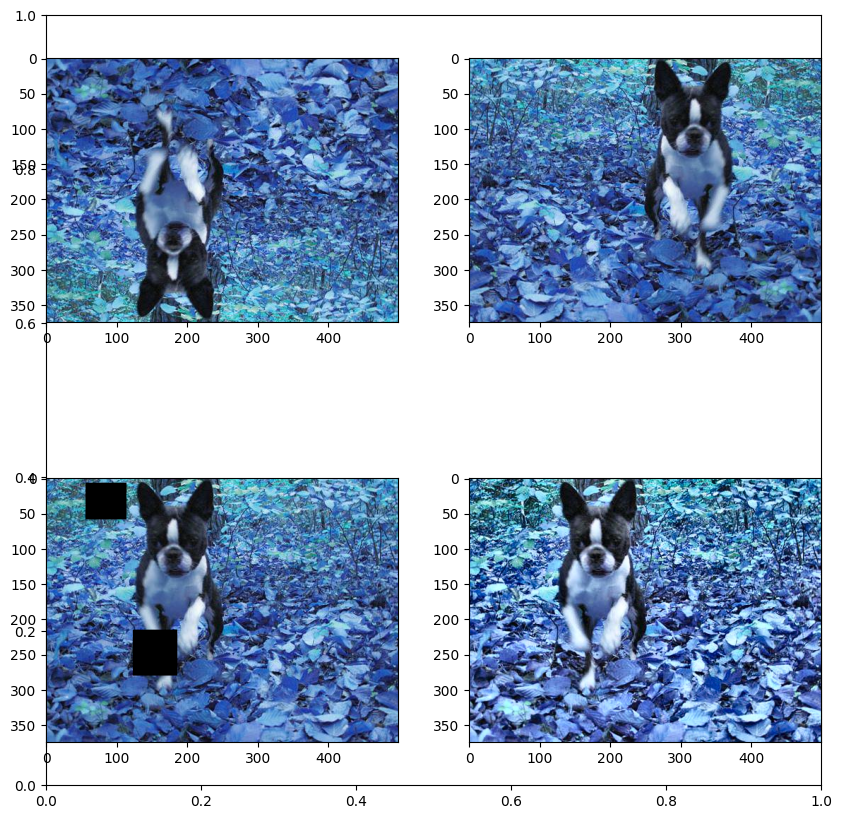

In [14]:
augments = [A.VerticalFlip(p=1), A.HorizontalFlip(p=1),
            A.CoarseDropout(p=1), A.CLAHE(p=1)]

plt.subplots(figsize=(10, 10))
for i, aug in enumerate(augments):
    plt.subplot(2, 2, i+1)
    aug_img = aug(image=img)['image']
    plt.imshow(aug_img)
plt.show()

In [15]:
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']

    return aug_img


@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)

    return img, label


def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label, depth=120, dtype=tf.float32)

In [16]:
train_ds = (tf.data.Dataset.from_tensor_slices((X_train, Y_train)).map(decode_image, num_parallel_calls=AUTO).map(partial(process_data), num_parallel_calls=AUTO)
                                          .batch(32).prefetch(AUTO))

val_ds = (tf.data.Dataset.from_tensor_slices((X_val, Y_val)).map(decode_image, num_parallel_calls=AUTO).batch(32).prefetch(AUTO))

In [17]:
for img, label in train_ds.take(1):
  print(img.shape, label.shape)

(32, 128, 128, 3) (32, 120)


In [18]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape=(128, 128, 3),weights='imagenet',include_top=False)

In [19]:
len(pre_trained_model.layers)

311

In [20]:
pre_trained_model.layers

[<InputLayer name=input_layer, built=True>,
 <Conv2D name=conv2d, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Activation name=activation, built=True>,
 <Conv2D name=conv2d_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Activation name=activation_1, built=True>,
 <Conv2D name=conv2d_2, built=True>,
 <BatchNormalization name=batch_normalization_2, built=True>,
 <Activation name=activation_2, built=True>,
 <MaxPooling2D name=max_pooling2d, built=True>,
 <Conv2D name=conv2d_3, built=True>,
 <BatchNormalization name=batch_normalization_3, built=True>,
 <Activation name=activation_3, built=True>,
 <Conv2D name=conv2d_4, built=True>,
 <BatchNormalization name=batch_normalization_4, built=True>,
 <Activation name=activation_4, built=True>,
 <MaxPooling2D name=max_pooling2d_1, built=True>,
 <Conv2D name=conv2d_8, built=True>,
 <BatchNormalization name=batch_normalization_8, built=True>,
 <Activation name=activation_8, built=True>,


In [21]:
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

last layer output shape:  (None, 6, 6, 768)


In [22]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(optimizer='adam',loss=keras.losses.CategoricalCrossentropy(from_logits=True),metrics=[tf.keras.metrics.AUC()])


In [23]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
	def on_epoch_end(self, epoch, logs={}):
		if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
			print('\n Validation accuracy has reached upto 90% so, stopping further training.')
			self.model.stop_training = True

es = EarlyStopping(patience=3, monitor='val_auc', restore_best_weights=True, mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',patience=2,factor=0.5,verbose=1)

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1, callbacks=[es, lr, myCallback()])

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['auc', 'val_auc']].plot()
plt.show()